In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
        #print(os.path.join(dirname, filename))



In [3]:
## Install Libraries
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, MaxPooling2D, DepthwiseConv2D, UpSampling2D, Dense, Reshape, Conv2D, Flatten, Conv2DTranspose, BatchNormalization, LeakyReLU, Activation, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras import optimizers


# Visualization (load and display images)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image 

In [4]:
# Set up Environment

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

    
print('Number of replicas:', strategy.num_replicas_in_sync)

# To optimize performance, we make use of AUTOTUNE with TensorFlow.

AUTOTUNE = tf.data.experimental.AUTOTUNE


Number of replicas: 1


# Project Topic: Style Transfer with GAN models

## Objective: 
-  Develop a neural style transfer model to transform normal photographs into Claude Monet's paintings style, demonstrating the application of deep learning in creative and artistic domains.
-  Style Transfer is a technique in computer vision and graphics that involves generating a new image by combining the content of one image with the style of another image. 
- The goal of style transfer is to create an image that preserves the content of the original image while applying the visual style of another image.## Objective: 
### Develop a neural style transfer model to transform normal photographs into Claude Monet's paintings style, demonstrating the application of deep learning in creative and artistic domains.
### Style Transfer is a technique in computer vision and graphics that involves generating a new image by combining the content of one image with the style of another image. The goal of style transfer is to create an image that preserves the content of the original image while applying the visual style of another image.

## Data:
- The dataset contains photos and monet paintings in jpeg and tfrec format.
- There are 
  -- 300  monet paintings in jpeg format.
  -- 7038 photos in jpeg format.
  -- 5 monet paintings in tfrec format.
  -- 20 photos in tfrec format.
- All the images are in color scale with 3 channels and has same dimensions of 256 X 256.

## Exploratory Data Analysis
- Lets visualize some images from all 4 different formats.

### JPEG Photo and Monet Images

In [5]:
# JPEG monet Count
monet_jpg_path = '/kaggle/input/gan-getting-started/monet_jpg/'
monet_jpg= os.listdir(monet_jpg_path)
print("Number of JPEG Monet images:", len(monet_jpg))

# how many pixels(shape) are in the image
img = mpimg.imread(os.path.join(monet_jpg_path, monet_jpg[0]))
print('Monet image shape:', img.shape)


Number of JPEG Monet images: 300
Monet image shape: (256, 256, 3)


In [ ]:
# Visualize the monet jpg images
fig = plt.figure(figsize=(20,10))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    im = Image.open(monet_jpg_path + monet_jpg[i])
    plt.title('Monet_{}'.format(i+1))
    plt.imshow(im)
    

In [8]:
# JPEG Photo Count
photo_jpg_path = '/kaggle/input/gan-getting-started/photo_jpg/'
photo_jpg = os.listdir(photo_jpg_path)
print("Number of JPEG Photo images:", len(photo_jpg))

# how many pixels(shape) are in the image
img = mpimg.imread(os.path.join(photo_jpg_path, photo_jpg[0]))
print('Photo image shape:', img.shape)

Number of JPEG Photo images: 7038
Photo image shape: (256, 256, 3)


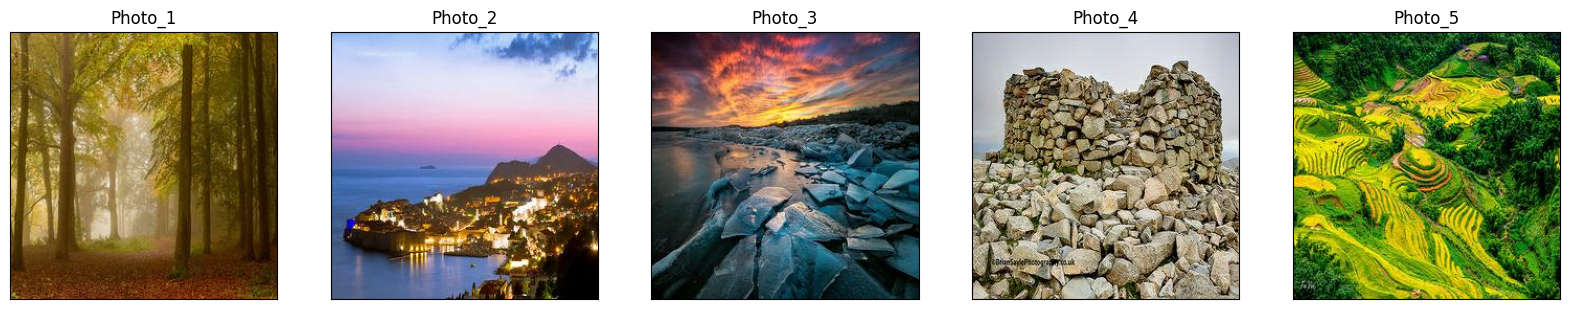

In [9]:
# Visualize the Photo jpg images 
fig = plt.figure(figsize=(20, 10))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    plt.title('Photo_{}'.format(i+1))
    im = Image.open(photo_jpg_path + photo_jpg[i])
    #print("height of the image is", im.height)
    #print("width of the image is", im.width)
    plt.imshow(im)

### TFREC Photo and Monet images

In [10]:
# TF Records Count
monet_tfrec_path = '/kaggle/input/gan-getting-started/monet_tfrec/'
MONET_FILENAMES = tf.io.gfile.glob(str(monet_tfrec_path + '*.tfrec'))
print('No. of Monet TFRecord Files:', len(MONET_FILENAMES))

photo_tfrec_path = '/kaggle/input/gan-getting-started/photo_tfrec/'
PHOTO_FILENAMES = tf.io.gfile.glob(str(photo_tfrec_path + '*.tfrec'))
print('No. of Photo TFRecord Files:', len(PHOTO_FILENAMES))


No. of Monet TFRecord Files: 5
No. of Photo TFRecord Files: 20


In [11]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [12]:
# Loading Dataset

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [13]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(5)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(5)

In [14]:
# The size of the images in monet and photo in tfrec format

def show_image_size(dataset):
    for image in dataset.take(1):
        image_shape = tf.shape(image)
        print(f"Image size: {image_shape.numpy()}") 

show_image_size(monet_ds)
show_image_size(photo_ds)

Image size: [  5 256 256   3]
Image size: [  5 256 256   3]


In [15]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

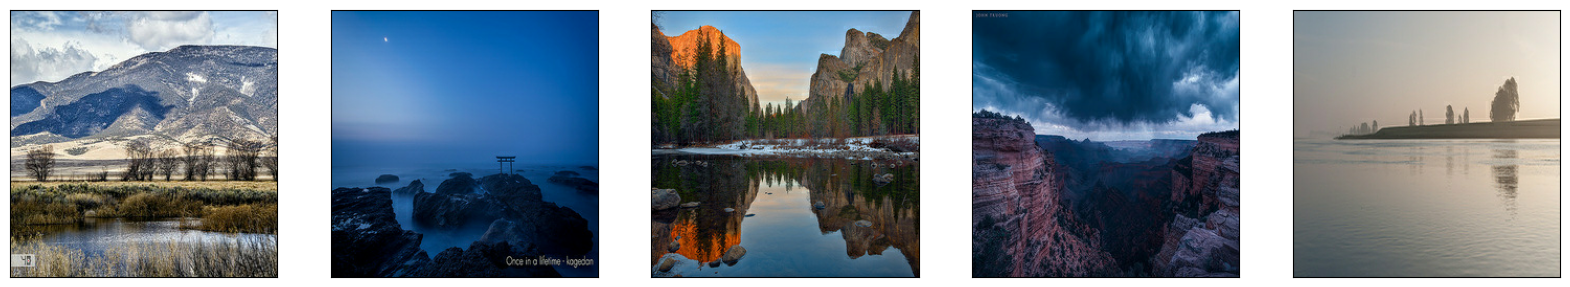

In [16]:
# Visualize the photo tfrecords images 

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(example_photo[i]* 0.5 + 0.5)
  

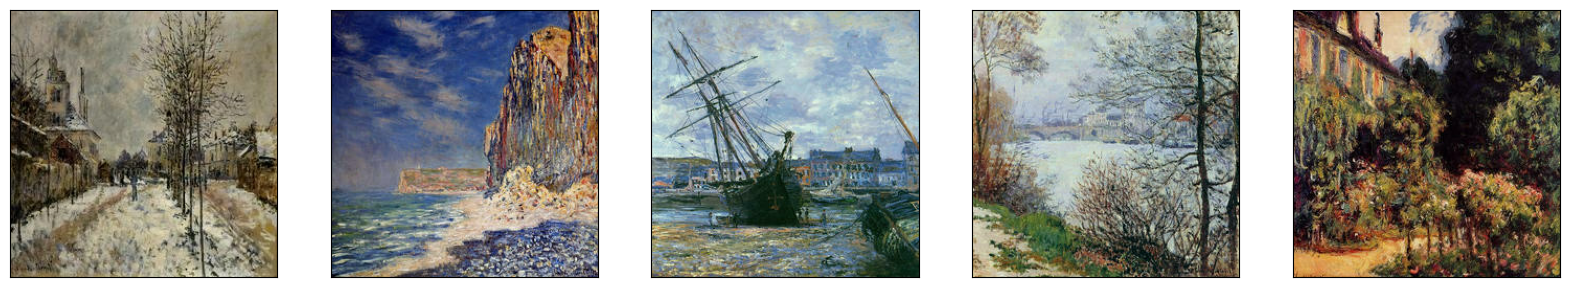

In [17]:
# Visualize the monet tfrecords images 
fig = plt.figure(figsize=(20, 8))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(example_monet[i]* 0.5 + 0.5)
   

# Model Architecture- CycleGAN
- CycleGAN is a generative adversarial network (GAN) architecture designed for image-to-image translation tasks, particularly when unpaired data is used.
- Our goal is to map images from one source domain to another target domain in the absence of paired images.

In [18]:
# Build the downsampler (encoder)
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)
   # gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = models.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_norm:
        #result.add(layers.InstanceNormalization(gamma_initializer=gamma_init))
        result.add(layers.GroupNormalization(groups = -1))
        
    result.add(layers.LeakyReLU())

    return result

In [19]:
# Build the upsampler (decoder)
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    #gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = models.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    #result.add(layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.GroupNormalization(groups = -1))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

# Generator

In [20]:
def model_generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 3, apply_norm=False), # (bs, 128, 128, 64)
        downsample(128, 3), # (bs, 64, 64, 128)
        downsample(256, 3), # (bs, 32, 32, 256)
        downsample(512, 3), # (bs, 16, 16, 512)
        downsample(512, 3), # (bs, 8, 8, 512)
        downsample(512, 3), # (bs, 4, 4, 512)
        downsample(512, 3), # (bs, 2, 2, 512)
        downsample(512, 3), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 3, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512,3, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 3, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 3), # (bs, 16, 16, 1024)
        upsample(256, 3), # (bs, 32, 32, 512)
        upsample(128, 3), # (bs, 64, 64, 256)
        upsample(64, 3), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return models.Model(inputs=inputs, outputs=x)

In [21]:
model_generator().summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      1,728 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │     73,984 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    295,424 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  1,180,672 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  2,360,320 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  2,360,320 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  2,360,320 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  2,360,320 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  2,360,320 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  4,719,616 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  4,719,616 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  4,719,616 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 30,613,187 (116.78 MB)

 Trainable params: 30,613,187 (116.78 MB)

 Non-trainable params: 0 (0.00 B)

# Discriminator

In [22]:
def model_discriminator():
    initializer = tf.random_normal_initializer(0.0, 0.02)
   # gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 3, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 3)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 3)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 3, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = layers.GroupNormalization(groups = -1)(conv)

    leaky_relu = layers.LeakyReLU(alpha = 0.2)(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 3, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return models.Model(inputs=inp, outputs=last)

In [23]:
model_discriminator().summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 128, 128, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 64, 64, 128)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (None, 32, 32, 256)    │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 512)    │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_16          │ (None, 32, 32, 512)    │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 34, 34, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 1)      │         4,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,556,417 (5.94 MB)

 Trainable params: 1,556,417 (5.94 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Create Generators and Discriminators:
monet_generator = model_generator() # transforms photos to Monet paintings
photo_generator = model_generator() # transforms Monet paintings to be more like photos
monet_discriminator = model_discriminator() # differentiates real monet paintings and generated monet paintings
photo_discriminator = model_discriminator() # differentiates real photos and generated photos

## Loss and Optimizers

In [25]:
# Loss function for both models
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator loss 
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss * 0.5


# generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


LAMBDA = 10

def compute_cycle_loss(real_img, cycled_img):
    loss = tf.reduce_mean(tf.abs(real_img - cycled_img))
    return LAMBDA * loss

def identity_loss(real_img, same_img):
    loss = tf.reduce_mean(tf.abs(real_img - same_img))
    return LAMBDA * 0.5 * loss

In [ ]:
# Optimizers
#monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
#photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
#monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
#photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# Checkpoints
"""

CHECKPOINT_DIR = 'checkpoints/train'

ckpt = tf.train.Checkpoint(monet_generator=monet_generator,
                           photo_generator=photo_generator,
                           monet_discriminator=monet_discriminator,
                           photo_discriminator=photo_discriminator,
                           monet_generator_optimizer=monet_generator_optimizer,
                           photo_generator_optimizer=photo_generator_optimizer,
                           monet_discriminator_optimizer=monet_discriminator_optimizer,
                           photo_discriminator_optimizer=photo_discriminator_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_DIR, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')
  
"""


In [26]:
#cycle gan class setup
class CycleGAN(keras.Model):
    #initializez cycle gan
    def __init__(self, monet_generator, photo_generator, monet_discriminator,
                 photo_discriminator, lambda_cycle=10, lambda_identity=0.5):
        super().__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    #defines compile model function
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer,
                p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn,
                identity_loss_fn):
        super().compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    #defines training step
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        #records operations for gradient computations
        with tf.GradientTape(persistent=True) as tape:
            #forward passes
            fake_monet = self.m_gen(real_photo, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            #loss calculations
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            monet_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet) * self.lambda_cycle
            photo_cycle_loss = self.cycle_loss_fn(real_photo, cycled_photo) * self.lambda_cycle
            monet_identity_loss = self.identity_loss_fn(real_monet, same_monet) * self.lambda_cycle * self.lambda_identity
            photo_identity_loss = self.identity_loss_fn(real_photo, same_photo) * self.lambda_cycle * self.lambda_identity
            total_monet_gen_loss = monet_gen_loss + monet_cycle_loss + monet_identity_loss
            total_photo_gen_loss = photo_gen_loss + photo_cycle_loss + photo_identity_loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        #gradient calculations
        monet_gen_grads = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_disc_grads = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        #optimizers to update model weights
        self.m_gen_optimizer.apply_gradients(zip(monet_gen_grads, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_gen_grads, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_disc_grads, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_disc_grads, self.p_disc.trainable_variables))

        #returns losses
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss,
        }


In [27]:
#sets number of epochs
EPOCH_COUNT = 10

In [28]:
#model setup
model_gan = CycleGAN(
    monet_generator = monet_generator,
    photo_generator = photo_generator,
    monet_discriminator = monet_discriminator,
    photo_discriminator = photo_discriminator,
    lambda_cycle = 10,
    lambda_identity = 0.5)

In [29]:
#compiles model
model_gan.compile(
    m_gen_optimizer = keras.optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5),
    p_gen_optimizer = keras.optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5),
    m_disc_optimizer = keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.5),
    p_disc_optimizer = keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.5),
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = keras.losses.MeanAbsoluteError(),
    identity_loss_fn = keras.losses.MeanAbsoluteError())

In [30]:
monet_dataset = image_dataset_from_directory(
    monet_jpg_path,
    label_mode=None, 
    batch_size=8 
)

photo_dataset = image_dataset_from_directory(
    photo_jpg_path,
    label_mode=None, 
    batch_size=8 
)

# Repeat the datasets to have the same number of batches
#repeats = (7038 + 299) // 300

#monet_dataset = monet_dataset.repeat(repeats + 4)
#photo_dataset = photo_dataset.repeat(2)


# Normalize the images
dataset_monet = monet_dataset.map(lambda x: x / 255.0)
dataset_photo = photo_dataset.map(lambda x: x / 255.0)

Found 300 files.
Found 7038 files.


In [32]:
# Model fit
history = model_gan.fit(
    tf.data.Dataset.zip((dataset_monet, dataset_photo)),
    epochs = EPOCH_COUNT,
    verbose = 1)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 334ms/step - monet_disc_loss: 0.6848 - monet_gen_loss: 1.8620 - photo_disc_loss: 0.6602 - photo_gen_loss: 2.0194
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 335ms/step - monet_disc_loss: 0.6869 - monet_gen_loss: 1.8423 - photo_disc_loss: 0.6656 - photo_gen_loss: 2.0351
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 334ms/step - monet_disc_loss: 0.6904 - monet_gen_loss: 1.8245 - photo_disc_loss: 0.6603 - photo_gen_loss: 2.0327
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 335ms/step - monet_disc_loss: 0.6920 - monet_gen_loss: 1.7711 - photo_disc_loss: 0.6538 - photo_gen_loss: 2.0034
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 334ms/step - monet_disc_loss: 0.6936 - monet_gen_loss: 1.7708 - photo_disc_loss: 0.6555 - photo_gen_loss: 1.9986
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 335ms/step - monet_disc_loss: 0.6928 - monet_gen_loss: 1.7354 - photo_disc_loss: 0.6618 - photo_gen_loss: 1.9740
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 334ms/step - monet_disc_loss

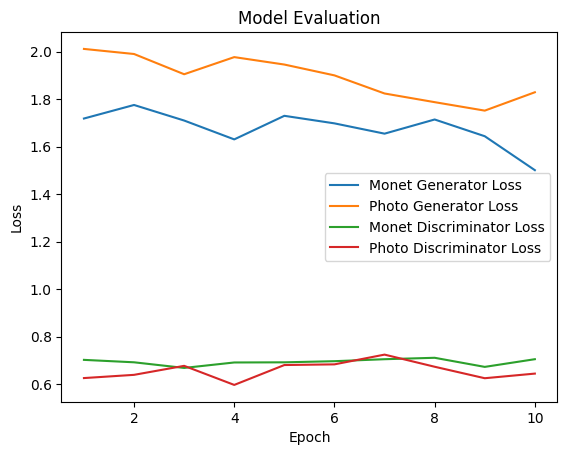

In [33]:
#sets the range of epochs for the x-axis
epochs = range(1, EPOCH_COUNT + 1)

#plots the losses for generators and discriminators
plt.plot(epochs, history.history["monet_gen_loss"], label = 'Monet Generator Loss')
plt.plot(epochs, history.history["photo_gen_loss"], label = 'Photo Generator Loss')
plt.plot(epochs, history.history["monet_disc_loss"], label = 'Monet Discriminator Loss')
plt.plot(epochs, history.history["photo_disc_loss"], label = 'Photo Discriminator Loss')

plt.title("Model Evaluation")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Results and Analysis:
- From the above graph we can see that the monet and photo discriminator loss is consistent between 0.5 and 1.
- The monet and photo generator loss is very high at the begining of training and decreased with more epochs.

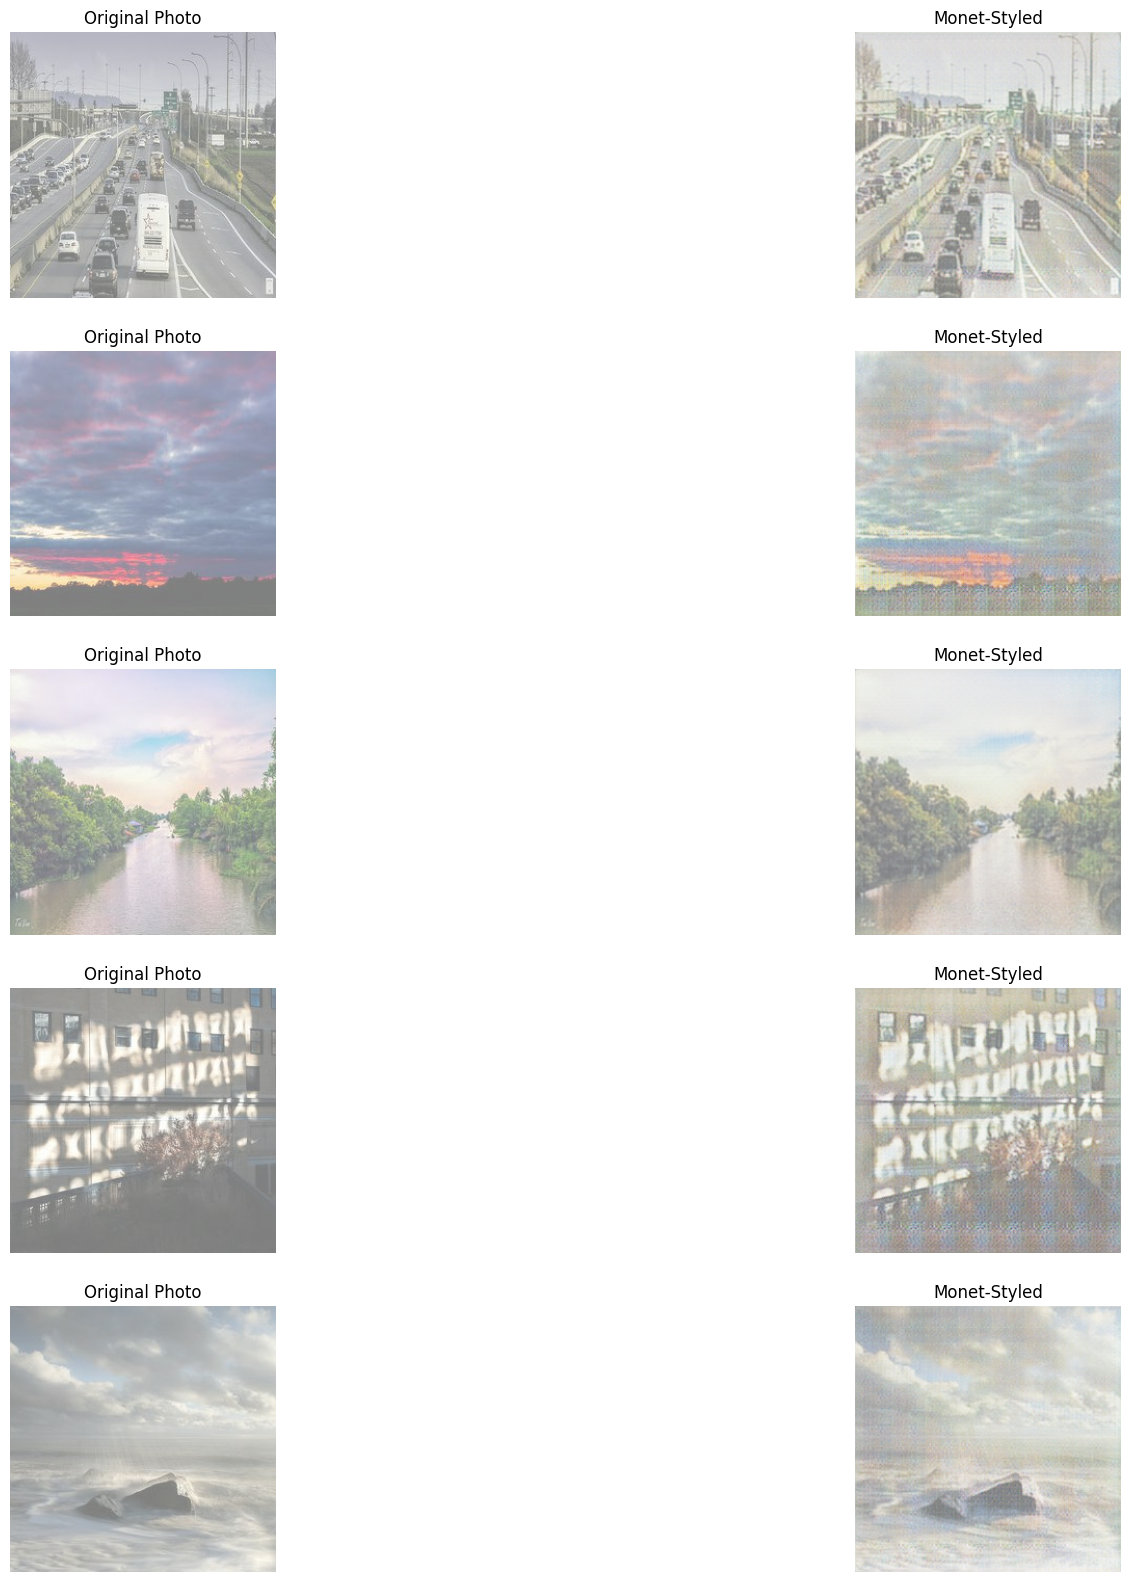

In [34]:

_, ax = plt.subplots(5, 2, figsize=(20,20))
for i, photo in enumerate(dataset_photo.take(5)):
    prediction = monet_generator(photo, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    photo_img = (photo[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i, 0].imshow(photo_img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Original Photo")
    ax[i, 1].set_title("Monet-Styled")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [37]:
os.makedirs('kaggle/working/tmp', exist_ok=True)
i=1
for img in dataset_photo:
    prediction = (monet_generator(img, training=False)[0].numpy().squeeze() * 255).astype(np.uint8)
    #prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    #for gen_img in prediction:i += 1
    img = Image.fromarray(prediction)
    img.save(os.path.join('kaggle/working/tmp'+ str(i) + '.jpg'))
        

In [39]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', 'tmp')

'/kaggle/working/images.zip'


## Conclusions
- I trained the cycleGAN model for 10 epochs and the model generated monet style photos and the transformed images maintained the structural integrity and key features of the original photographs.
- The model could be trained with more epochs if time permits for better generation of monet sytle photos.
- The generated images were zipped into images.zip file and submitted to the competition.

